**MLP : метод обратного распространения ошибки**

два обрабатывающих слоя,  
потеря MSQE,  
активация сигмоид

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## строим датасет

In [2]:
from time import time
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

In [3]:
N_SAMPLES = 3000 # количество примеров

In [4]:
from sklearn.datasets import make_circles

X,y = make_circles(n_samples=N_SAMPLES, shuffle=True, noise=None, random_state=get_seed(), factor=0.3)
X = X+(np.random.rand(X.shape[0],X.shape[1])*0.6)

In [5]:
# from sklearn.datasets import make_moons

# X,y = make_moons(n_samples=N_SAMPLES, noise=.09, random_state=get_seed())

In [6]:
# from sklearn.datasets import make_blobs

# X,y = make_blobs( 
#         n_samples=N_SAMPLES,
#         centers=2,  
#         random_state=get_seed(),
#         cluster_std=[1.0, 2.5,]
#     )

In [7]:
from sklearn.preprocessing import OneHotEncoder

# формируем вектор-выход сети {-1,1}
y = OneHotEncoder(sparse=False,categories='auto').fit_transform( y[np.newaxis,:].T )*2-1

# нормируем данные
X = ( X - X.min(axis=0) ) / ( X.max(axis=0) - X.min(axis=0) )

X.shape, y.shape

((3000, 2), (3000, 2))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=512)
y_train.shape[0], y_test.shape[0]

(1200, 1800)

In [9]:
# y

In [10]:
# plt.scatter(X[:,0],X[:,1],c=y[:,1])

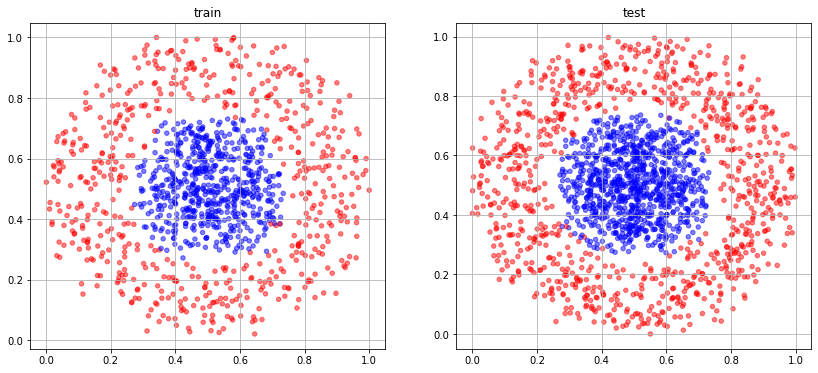

In [11]:
f, axarr = plt.subplots(1,2, sharey=False, sharex=False, figsize=(14,6),)

i=0
y = np.argmax(y_train,axis=1)
axarr[i].set_title('train')
axarr[i].scatter( 
             x=X_train[:,0], 
             y=X_train[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y ], 
             s=20,
             alpha=0.5 )
axarr[i].grid()


i+=1
y = np.argmax(y_test,axis=1)
axarr[i].set_title('test')
axarr[i].scatter( 
             x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

plt.show()

In [12]:
%xdel X
%xdel y

## строим сеть

In [13]:
# ф-ция активации слоёв
def act(z): return np.tanh(z)

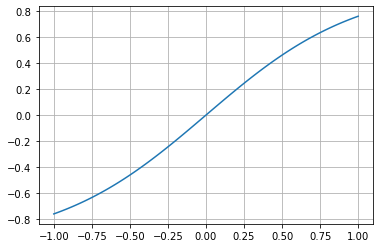

In [14]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act(jj) )
plt.grid()
plt.show()

In [15]:
# производная ф-ции активации слоёв
def act_drv(z): return 1.0/(np.cosh(z)**2)

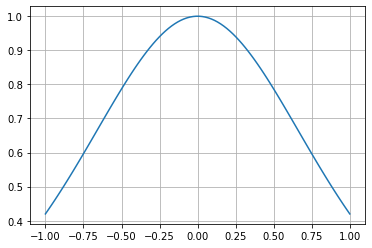

In [16]:
jj = np.linspace(-1.0,1.0,100)
plt.plot( jj, act_drv(jj) )
plt.grid()
plt.show()

In [17]:
# MSQE
def loss(o,y):
    e = (o-y).flatten() # ошибки примеров
    e = ( e.T.dot(e) )*(1.0/y.shape[0])  # средняя квадратичная ошибка
    assert ~np.isnan(e), 'ошибка вычислений'
    return e

---

In [18]:
# выход
def run(x): 
    return act( act( x.dot(W0) + S0 ).dot(W1) + S1 ) # выход сети


In [19]:
# прямой проход
def forward(x):
    L = [ x.dot(W0) + S0 ] # состояние (не активированное) скрытого слоя
    L.append( act(L[0]).dot(W1) + S1   ) # состояние (не активированное) выходного слоя
    return L


In [20]:
# обратный проход
def backward(L,y):
    O = act(L[1]) # выход сети
    E = [ (O-y)*act_drv(L[1]) ] # ошибка выходного слоя
    E.insert(0, E[0].dot(W1.T)*act_drv(L[0]) ) # ошибка скрытого слоя
    return E


In [21]:
# градиент
def grad(X,L,E):
    GW = [ X.T.dot(E[0]) ] # градиент по весам скрытого слоя
    GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

    O = act(L[0]) # выход скрытого слоя
    GW.append( O.T.dot(E[1]) ) # градиент по весам выходного слоя
    GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

    return GW,GS


In [22]:
# нормируем градиент
def grad_norm(gw,gs):
    mw = np.abs(np.hstack([ gw[0].flatten(), gw[1].flatten(), gs[0], gs[1], ])).max()
        
    if mw != 0.0:
        gw[0] /= mw
        gw[1] /= mw
        gs[0] /= mw
        gs[1] /= mw
    
    return gw,gs


## обучаем сеть

In [23]:
# размер скрытого слоя
S_LAYER = 10

In [24]:
# инициализация весов и сдвигов
W0 = np.random.normal(loc=0.0, scale=0.1, size=[X_train.shape[1],S_LAYER])
S0 = np.zeros(S_LAYER)

W1 = np.random.normal(loc=0.0, scale=0.1, size=[S_LAYER,y_train.shape[1] ])
S1 = np.zeros(y_train.shape[1])

In [25]:
# метод градиентного спуска

a=0.02 # скорость обучения
r=0.001 # регуляризация
m=0.001 # момент

# ex_count = X.shape[0]   # количество примеров

# максимальное число циклов обучения
MAX_ITER = 1500

MIN_ERROR = 0.14 # порог минимальной ошибки

err =[1e7] 

dW1=dW0=dS0=dS1=0.0

In [26]:
for i in range(MAX_ITER):
    O = run(X_train) # выход сети
    err.append( loss(O,y_train) ) # история значений ф-ции потери
    
    if err[-1] < MIN_ERROR: # проверяем достижение порога
        break

    L=forward(X_train) # прямой проход
    E=backward(L,y_train) # обратный проход
    GW,GS = grad(X_train,L,E) # градиент
    GW,GS = grad_norm(GW,GS) # нормируем градиент
    
    
    dW0 = a*( GW[0]+ r*W0 ) + m*dW0
    dW1 = a*( GW[1]+ r*W1 ) + m*dW1
    dS0 = a*GS[0]+ m*dS0
    dS1 = a*GS[1]+ m*dS1
    
    # изменяем веса и сдвиги
    W0 -= dW0
    W1 -= dW1 
    S0 -= dS0
    S1 -= dS1

print('step:',i,'/',MAX_ITER)
print('error:',err[-1],'/',MIN_ERROR)

step: 1499 / 1500
error: 0.2824991327164145 / 0.14


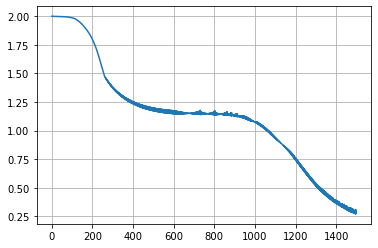

In [27]:
# изменение ошибки обучения
fig, ax = plt.subplots()
ax.plot(err[2:])
plt.grid()
plt.show()

## тестируем

In [28]:
# результат
p = run(X_test)
print(loss(p,y_test)) # потеря MSQE на тесте

0.2664676767702032


In [29]:
y_t = np.argmax(y_test,axis=1) 
y_o = np.argmax(p,axis=1)

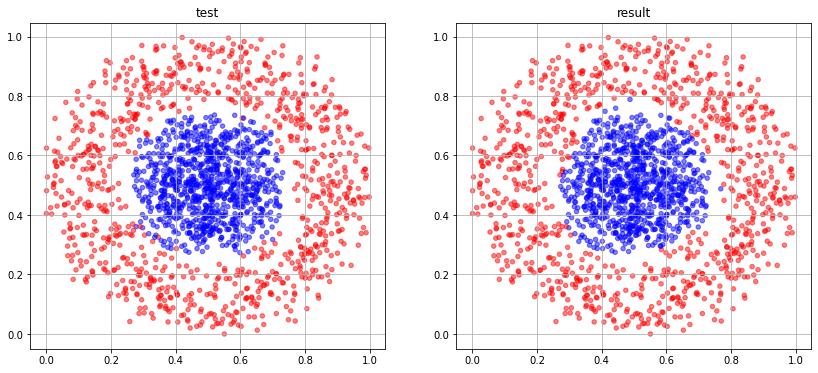

In [30]:
f, axarr = plt.subplots(1,2, sharey=False, sharex=False, figsize=(14,6),)

i=0
axarr[i].set_title('test')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_t], 
             s=20,
             alpha=0.5 )
axarr[i].grid()



i+=1
axarr[i].set_title('result')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'r' if(j<1) else 'b' for j in y_o ],     
             s=20,
             alpha=0.5 )
axarr[i].grid()


plt.show()

### метрики качества

In [31]:
from sklearn.metrics import classification_report
print( classification_report( y_t, y_o ) )

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       905
           1       0.99      0.97      0.98       895

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



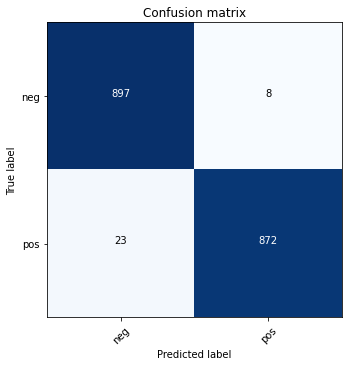

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_t,y_o)

classes = ['neg','pos'] 
tick_marks = np.arange(len(classes))

plt.figure(figsize=(5,5))


plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')

# # plt.colorbar()


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

----

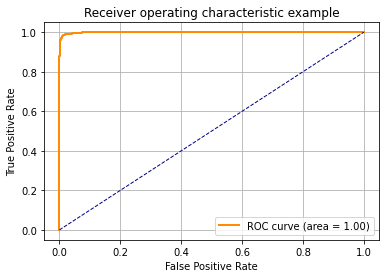

In [33]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# p = run(X_test) 

fpr, tpr, thresholds = roc_curve( y_t, p[:,1] )
roc_auc = auc(fpr,tpr)

plt.figure()
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

----

In [34]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки

xx.shape, yy.shape

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
xy.shape

(250000, 2)

In [35]:
rr = np.argmax( run(xy),axis=1 ).reshape(n,n) # вычисляем результат для каждого узла сетки

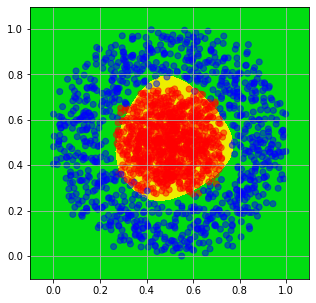

In [36]:
from matplotlib.colors import ListedColormap
cm=ListedColormap(['#00dd11','#eeee00'])

plt.figure(figsize=(5,5))

plt.contourf(xx, yy, rr, cmap=cm)

c = [ ['b','r'][ int(j>0.5) ] for j in y_t  ]
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=c, alpha=.5 )

plt.grid()
plt.show()